In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#Base
import sys, os
import numpy as np
import pandas as pd
import json
import h5py
import seaborn as sns
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# README

Use these precomputed metrics at your own risk or compute your own and compare! We calculated various functional metrics for each stimulus over 2 years ago, but never really did anything with them other than the surround suppression index. All of the metrics, with the exception of the receptive field locations, were calculated using the deconvolved events instead of the delta-fluorescence. If you were to recompute some of these metrics using dF/F instead, you would probably get different results. Maybe one way is better than the other? The receptive field locations were calculated using the locally sparse noise stimulus set, in a GLM framework to identify which regions on the screen a roi is responsive to. If you were to use another stimulus set, like drifting gratings, you may get a different receptive field location and shape. The surround suppression index was calculated using both the drifting gratings full field and windowed stimulus sets. The various SSI metrics are as follows:
- "ssi": "Computed from pref DGW condition and DGF response at that condition",
- "ssi_avg": "Computed from average DGW and DGF responses (across direction and spatial freq.)",
- "ssi_avg_at_pref_sf": "Computed from average DGW and DGF responses (across direction at preferred DGW spatial freq.)",
- "ssi_running_avg_at_pref_sf": "Computed from average DGW and DGF responses while mouse is running (>1 cm/s) (across direction at preferred DGW spatial freq.)",
- "ssi_stationary_avg_at_pref_sf": "Computed from average DGW and DGF responses while mouse is stationary (<1 cm/s) (across direction at preferred DGW spatial freq.)",
- "ssi_running": "Same as SSI, but while mouse is running (>1 cm/s). Must have at least 3 running trials in DGW and DGF.",
- "ssi_stationary": "Same as SSI, but while mouse is stationary (<1 cm/s). Must have at least 3 stationary trials in DGW and DGF.",
- "ssi_tuning_fit": "Computed from tuning curve fits. Uses DGW pref sf and corresponding tuning fit pref. dir. Then uses DGF tuning fit at that pref sf and dir."


Unfortunately the code we used to calculate these metrics did not use the NWBs as a data input, so it would not work with the format you have access to. The code used to calculate these metrics is located here: https://github.com/AllenInstitute/allen_v1dd


# Read in stimulus dataframes

In [4]:
rf_metrics_df = pd.read_csv('../../data_frames/rf_metrics_M409828.csv')
rf_metrics_df = rf_metrics_df.astype({'column': 'int', 'volume': 'string', 'plane': 'int', 'roi': 'int'})


natural_images_df = pd.read_csv('../../data_frames/natural_images_M409828.csv')
natural_images_df = natural_images_df.astype({'column': 'int', 'volume': 'string', 'plane': 'int', 'roi': 'int','frac_responsive_trials': 'float'})

natural_images_12_df = pd.read_csv('../../data_frames/natural_images_12_M409828.csv')
natural_images_12_df = natural_images_12_df.astype({'column': 'int', 'volume': 'string', 'plane': 'int', 'roi': 'int','frac_responsive_trials': 'float'})

ssi_df = pd.read_csv('../../data_frames/surround_supression_index_M409828.csv')
ssi_df = ssi_df.astype({'column': 'int', 'volume': 'string', 'plane': 'int', 'roi': 'int'})

natural_movie_df = pd.read_csv('../../data_frames/natural_movie_M409828.csv')
natural_movie_df = natural_movie_df.astype({'column': 'int', 'volume': 'string', 'plane': 'int', 'roi': 'int','frac_responsive_trials': 'float'})

drifting_gratings_windowed_df = pd.read_csv('../../data_frames/drifting_gratings_windowed_M409828.csv')
drifting_gratings_windowed_df = drifting_gratings_windowed_df.astype({'column': 'int', 'volume': 'string', 'plane': 'int', 'roi': 'int', 'dsi': 'float',
       'frac_responsive_trials': 'float', 'gosi': 'float', 'lifetime_sparseness': 'float', 'osi': 'float', 'preferred_dir': 'float', 'preferred_sf': 'float',
       'pref_dir_mean': 'float'})

drifting_gratings_full_df = pd.read_csv('../../data_frames/drifting_gratings_full_M409828.csv')
drifting_gratings_full_df = drifting_gratings_full_df.astype({'column': 'int', 'volume': 'string', 'plane': 'int', 'roi': 'int', 'dsi': 'float',
       'frac_responsive_trials': 'float', 'gosi': 'float', 'lifetime_sparseness': 'float', 'osi': 'float', 'preferred_dir': 'float', 'preferred_sf': 'float',
       'pref_dir_mean': 'float'})


/tmp/ipykernel_998307/241177631.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  rf_metrics_df = pd.read_csv('../../data_frames/rf_metrics_M409828.csv')
/tmp/ipykernel_998307/241177631.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  natural_images_df = pd.read_csv('../../data_frames/natural_images_M409828.csv')
/tmp/ipykernel_998307/241177631.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  natural_images_12_df = pd.read_csv('../../data_frames/natural_images_12_M409828.csv')
/tmp/ipykernel_998307/241177631.py:11: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ssi_df = pd.read_csv('../../data_frames/surround_supression_index_M409828.csv')
/tmp/ipykernel_998307/241177631.py:14: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set 

# Look at co-registered cells and see which neurons have metrics calculated

In [3]:
# Import packages
from caveclient import CAVEclient

# Token Generation and Setup
CAVEclient.setup_token("https://global.em.brain.allentech.org")

# Initialize CAVEclient
client = CAVEclient(datastack_name="v1dd_public", version=1196)

coreg_df = client.materialize.query_table("functional_coregistration_manual_2")[["pt_root_id", "column", "volume", "plane", "roi"]]

Visit https://global.em.brain.allentech.org/sticky_auth/settings/tokens and copy an existing token or create a new one.
All datastacks are configured to use this server address.
You will not need to specify a server address when initializing a client for configured datastacks in the future.
Setup complete!


In [4]:
coreg_df = coreg_df.astype({'pt_root_id': int, 'column': int, 'volume': str, 'plane': int, 'roi': int})
coreg_df

,pt_root_id,column,volume,plane,roi
0,864691132830842994,1,3,0,143
1,864691132741466457,1,3,2,40
2,864691132770893729,1,3,3,98
3,864691132770893729,1,3,3,98
4,864691132999240117,1,3,0,100
...,...,...,...,...,...
566,864691132744008540,1,3,2,236
567,864691132810202401,1,3,2,383
568,864691132925592361,1,3,2,393
569,864691132884727983,1,3,0,89


In [5]:
np.unique(coreg_df['column'],return_counts=True)

(array([1, 2]), array([487,  84]))

In [6]:
np.unique(coreg_df['volume'],return_counts=True)

(array(['3', '5'], dtype=object), array([364, 207]))

# Merge coregistered table with metrics

In [8]:
coreg_RF_df = pd.merge(coreg_df, rf_metrics_df, on=['column','volume','plane','roi'])
coreg_RF_df 

,pt_root_id,column,volume,plane,roi,roi_unique_id,mouse,has_rf_on,has_rf_off,has_rf_on_or_off,azimuth_rf_on,altitude_rf_on,azimuth_rf_off,altitude_rf_off
0,864691132830842994,1,3,0,143,M409828_3_0_143,M409828,False,False,False,NaN,NaN,NaN,NaN
1,864691132741466457,1,3,2,40,M409828_3_2_40,M409828,True,True,True,4.317857,4.068750,17.271429,8.137500
2,864691132770893729,1,3,3,98,M409828_3_3_98,M409828,False,False,False,NaN,NaN,NaN,NaN
3,864691132770893729,1,3,3,98,M409828_3_3_98,M409828,False,False,False,NaN,NaN,NaN,NaN
4,864691132999240117,1,3,0,100,M409828_3_0_100,M409828,False,False,False,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566,864691132744008540,1,3,2,236,M409828_3_2_236,M409828,True,True,True,-0.549545,-0.961705,-0.392532,1.109659
567,864691132810202401,1,3,2,383,M409828_3_2_383,M409828,False,False,False,NaN,NaN,NaN,NaN
568,864691132925592361,1,3,2,393,M409828_3_2_393,M409828,False,False,False,NaN,NaN,NaN,NaN
569,864691132884727983,1,3,0,89,M409828_3_0_89,M409828,False,True,True,NaN,NaN,-21.589286,4.068750


In [9]:
nCells_with_RF = np.sum(coreg_RF_df['has_rf_on_or_off'])
print(f"Number of cells with RF: {nCells_with_RF} / {len(coreg_RF_df)} ({nCells_with_RF/len(coreg_RF_df)*100:.2f}%)")

Number of cells with RF: 221 / 571 (38.70%)


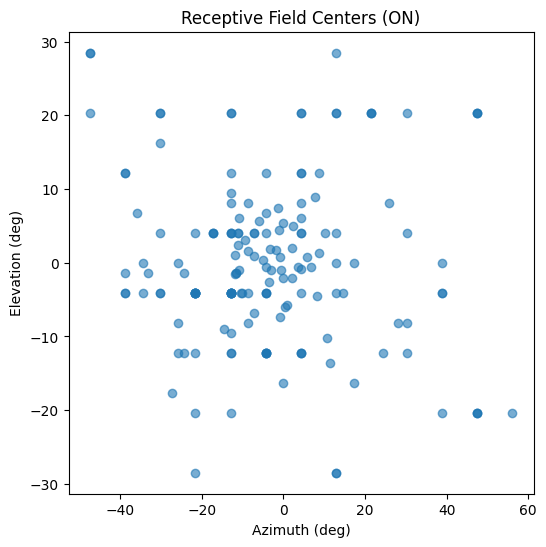

In [13]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(coreg_RF_df['azimuth_rf_on'], coreg_RF_df['altitude_rf_on'], alpha=0.6)
ax.set_xlabel('Azimuth (deg)')
ax.set_ylabel('Elevation (deg)')
ax.set_title('Receptive Field Centers (ON)')
plt.show()

In [15]:
coreg_DGW_df = pd.merge(coreg_df, drifting_gratings_windowed_df, on=['column','volume','plane','roi'])
coreg_DGW_df 

,pt_root_id,column,volume,plane,roi,roi_unique_id,mouse,dsi,frac_responsive_trials,gosi,is_responsive,lifetime_sparseness,osi,preferred_dir,preferred_sf,pref_dir_mean
0,864691132830842994,1,3,0,143,M409828_3_0_143,M409828,0.310410,0.500000,0.148564,1.0,0.680570,0.641220,240.0,0.04,268.201119
1,864691132741466457,1,3,2,40,M409828_3_2_40,M409828,0.109174,0.333333,0.315818,0.0,0.705311,0.563333,270.0,0.08,62.354705
2,864691132770893729,1,3,3,98,M409828_3_3_98,M409828,0.819197,0.875000,0.654353,1.0,0.913946,0.910913,300.0,0.04,305.892101
3,864691132770893729,1,3,3,98,M409828_3_3_98,M409828,0.819197,0.875000,0.654353,1.0,0.913946,0.910913,300.0,0.04,305.892101
4,864691132999240117,1,3,0,100,M409828_3_0_100,M409828,0.465405,0.000000,0.091989,0.0,0.741865,0.507929,30.0,0.04,13.845667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566,864691132744008540,1,3,2,236,M409828_3_2_236,M409828,0.539777,0.250000,0.076815,0.0,0.717476,0.278803,150.0,0.08,172.618093
567,864691132810202401,1,3,2,383,M409828_3_2_383,M409828,0.504875,0.166667,0.084521,0.0,0.659792,0.309266,30.0,0.04,115.062045
568,864691132925592361,1,3,2,393,M409828_3_2_393,M409828,0.133803,0.375000,0.126713,0.0,0.639957,0.318682,90.0,0.04,29.526858
569,864691132884727983,1,3,0,89,M409828_3_0_89,M409828,0.675580,0.250000,0.286643,0.0,0.806431,0.758079,210.0,0.04,249.488916


In [102]:
nCells_response_DGW = np.sum(coreg_DGW_df['is_responsive'])
print(f"Number of cells responsive to drifting gratings windowed: {nCells_response_DGW} / {len(coreg_DGW_df)} ({nCells_response_DGW/len(coreg_DGW_df)*100:.2f}%)")

Number of cells responsive to drifting gratings windowed: 183.0 / 571 (32.05%)


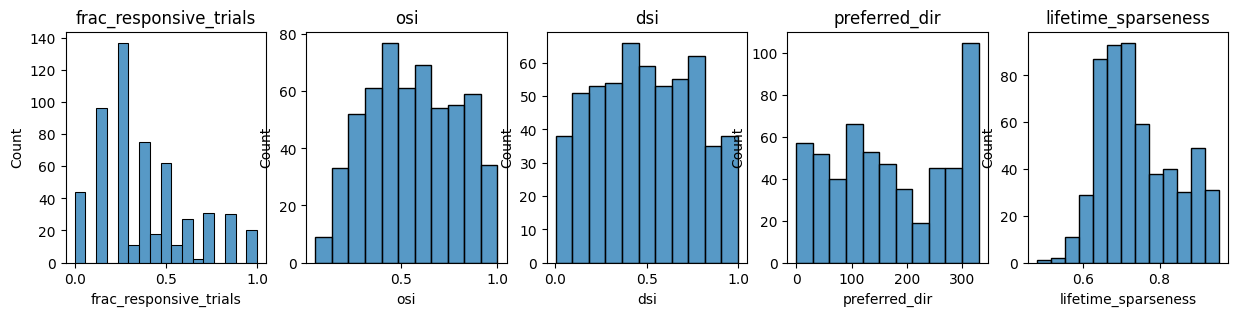

In [25]:
plot_vars = ['frac_responsive_trials','osi','dsi','preferred_dir','lifetime_sparseness']
fig, axes = plt.subplots(1,5,figsize=(15,3))
for ax, var in zip(axes, plot_vars):
    sns.histplot(coreg_DGW_df[var], ax=ax)
    ax.set_title(var)
# sns.histplot(coreg_DGW_df['osi'], ax=ax)
plt.show()

In [26]:
coreg_DGF_df = pd.merge(coreg_df, drifting_gratings_full_df, on=['column','volume','plane','roi'])
coreg_DGF_df 

,pt_root_id,column,volume,plane,roi,roi_unique_id,mouse,dsi,frac_responsive_trials,gosi,is_responsive,lifetime_sparseness,osi,preferred_dir,preferred_sf,pref_dir_mean
0,864691132830842994,1,3,0,143,M409828_3_0_143,M409828,0.219837,0.142857,0.114320,0.0,0.735508,0.282126,0.0,0.04,38.619296
1,864691132741466457,1,3,2,40,M409828_3_2_40,M409828,1.000000,0.142857,0.151315,0.0,0.767972,0.212644,0.0,0.04,340.624115
2,864691132770893729,1,3,3,98,M409828_3_3_98,M409828,0.306690,0.375000,0.176041,0.0,0.665264,0.380897,330.0,0.04,98.510223
3,864691132770893729,1,3,3,98,M409828_3_3_98,M409828,0.306690,0.375000,0.176041,0.0,0.665264,0.380897,330.0,0.04,98.510223
4,864691132999240117,1,3,0,100,M409828_3_0_100,M409828,0.804869,0.285714,0.059503,0.0,0.786891,0.360437,90.0,0.04,50.295803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,864691132744008540,1,3,2,236,M409828_3_2_236,M409828,0.177848,0.375000,0.012323,0.0,0.722536,0.166078,270.0,0.04,12.763168
483,864691132810202401,1,3,2,383,M409828_3_2_383,M409828,0.552722,0.500000,0.330917,1.0,0.830451,0.801532,270.0,0.04,285.872583
484,864691132925592361,1,3,2,393,M409828_3_2_393,M409828,0.609326,0.125000,0.105040,0.0,0.738667,0.643027,180.0,0.08,207.356691
485,864691132884727983,1,3,0,89,M409828_3_0_89,M409828,0.211490,0.285714,0.058823,0.0,0.786539,0.061027,0.0,0.04,11.675756


In [27]:
nCells_response_DGF = np.sum(coreg_DGF_df['is_responsive'])
print(f"Number of cells responsive to drifting gratings full: {nCells_response_DGF} / {len(coreg_DGF_df)} ({nCells_response_DGF/len(coreg_DGF_df)*100:.2f}%)")

Number of cells responsive to drifting gratings full: 161.0 / 487 (33.06%)


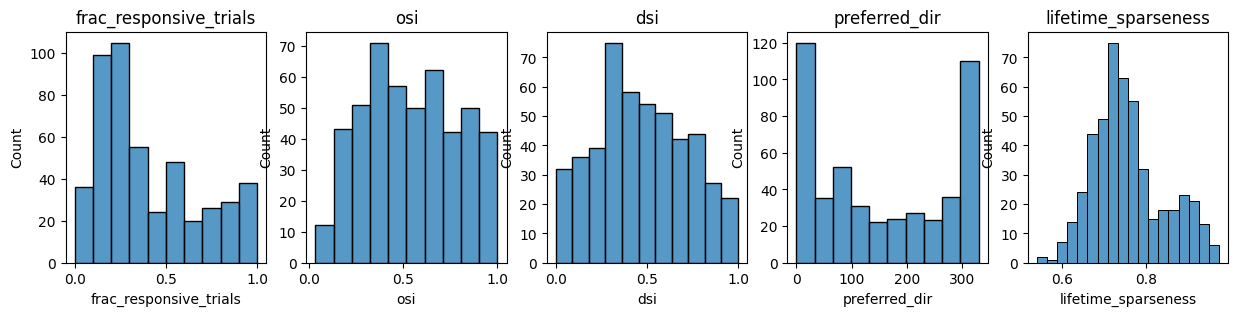

In [28]:
plot_vars = ['frac_responsive_trials','osi','dsi','preferred_dir','lifetime_sparseness']
fig, axes = plt.subplots(1,5,figsize=(15,3))
for ax, var in zip(axes, plot_vars):
    sns.histplot(coreg_DGF_df[var], ax=ax)
    ax.set_title(var)
# sns.histplot(coreg_DGW_df['osi'], ax=ax)
plt.show()

In [29]:
coreg_SSI_df = pd.merge(coreg_df, ssi_df, on=['column','volume','plane','roi'])
coreg_SSI_df


,pt_root_id,column,volume,plane,roi,roi_unique_id,mouse,ssi,ssi_avg,ssi_avg_at_pref_sf,ssi_running,ssi_running_avg_at_pref_sf,ssi_stationary,ssi_stationary_avg_at_pref_sf,ssi_tuning_fit
0,864691132830842994,1,3,0,143,M409828_3_0_143,M409828,0.690243,0.075104,0.071634,NaN,0.297138,NaN,-0.082219,0.462097
1,864691132741466457,1,3,2,40,M409828_3_2_40,M409828,0.618760,0.027850,0.196137,0.579922,0.411441,0.603451,0.040922,0.737050
2,864691132770893729,1,3,3,98,M409828_3_3_98,M409828,0.934504,0.300507,0.358062,NaN,0.206090,1.000000,0.379051,0.853644
3,864691132770893729,1,3,3,98,M409828_3_3_98,M409828,0.934504,0.300507,0.358062,NaN,0.206090,1.000000,0.379051,0.853644
4,864691132999240117,1,3,0,100,M409828_3_0_100,M409828,0.299111,-0.035332,-0.132033,0.435106,0.147266,-0.020467,-0.306339,0.051765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566,864691132744008540,1,3,2,236,M409828_3_2_236,M409828,0.278397,0.091721,0.199542,NaN,0.335268,NaN,0.296108,0.365780
567,864691132810202401,1,3,2,383,M409828_3_2_383,M409828,0.360188,-0.039540,-0.081416,0.242750,0.121519,0.513781,-0.232356,0.159941
568,864691132925592361,1,3,2,393,M409828_3_2_393,M409828,0.297351,0.168604,0.306620,NaN,0.326146,0.026797,0.308130,0.496217
569,864691132884727983,1,3,0,89,M409828_3_0_89,M409828,1.000000,0.194623,0.206886,NaN,0.282533,1.000000,0.065079,0.711100


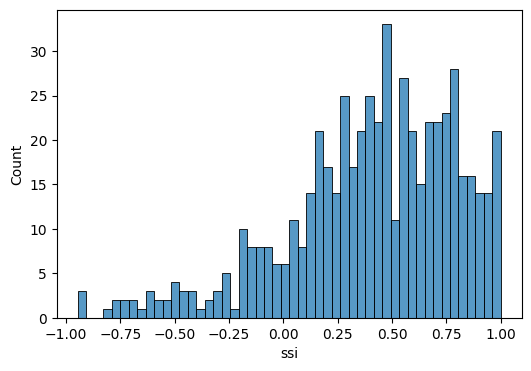

In [31]:
fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(coreg_SSI_df['ssi'], bins=50)
plt.show()

In [33]:
coreg_nat12_df = pd.merge(coreg_df, natural_images_12_df, on=['column','volume','plane','roi'])
coreg_nat12_df

,pt_root_id,column,volume,plane,roi,roi_unique_id,mouse,frac_responsive_trials,lifetime_sparseness,pref_img,pref_response,z_score
0,864691132830842994,1,3,0,143,M409828_3_0_143,M409828,1.000,0.936997,62,0.006905,18.981018
1,864691132741466457,1,3,2,40,M409828_3_2_40,M409828,0.175,0.960674,2,0.003816,3.835383
2,864691132770893729,1,3,3,98,M409828_3_3_98,M409828,0.200,0.946759,5,0.002400,5.235208
3,864691132770893729,1,3,3,98,M409828_3_3_98,M409828,0.200,0.946759,5,0.002400,5.235208
4,864691132999240117,1,3,0,100,M409828_3_0_100,M409828,1.000,0.961961,9,0.013189,19.708368
...,...,...,...,...,...,...,...,...,...,...,...,...
566,864691132744008540,1,3,2,236,M409828_3_2_236,M409828,1.000,0.960756,9,0.001727,4.972806
567,864691132810202401,1,3,2,383,M409828_3_2_383,M409828,0.075,0.963810,29,0.001473,2.300492
568,864691132925592361,1,3,2,393,M409828_3_2_393,M409828,1.000,0.953611,2,0.003873,8.795009
569,864691132884727983,1,3,0,89,M409828_3_0_89,M409828,1.000,0.978015,2,0.006449,15.733704


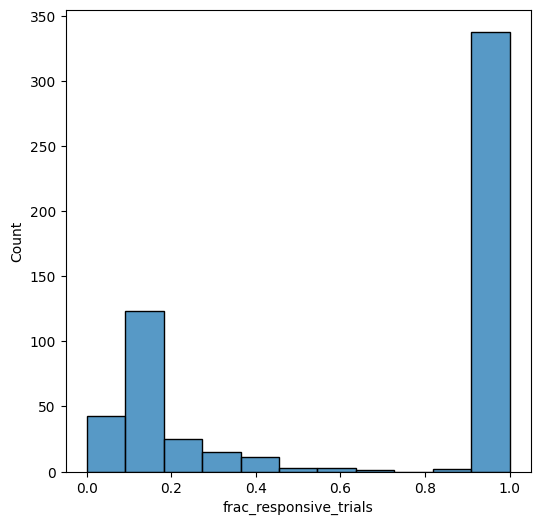

In [42]:
fig,ax = plt.subplots(figsize=(6,6))
# ax.scatter(coreg_RF_df['azimuth_rf_on'], coreg_RF_df['altitude_rf_on'], alpha=0.6)
sns.histplot(coreg_nat12_df['frac_responsive_trials'])
plt.show()